# 1. How HMP works: practical, methodological and theoretical grounds

## Data 

### Simulation

We will start by simulating data to demonstrate the HMP analysis on simulated data.
First, we need to load several libraries, after which we simulate a dataset with 4 events and the resulting 5 inter-event times (stimulus -> event 1, event 1 -> event 2, ..., event 4 -> response.

> [!NOTE]
> Most of this code is specific to simulation cases, to apply to your own data, use the code of the next tutorials



In [1]:
## Importing these packages is specific for this simulation case
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

## Importing HMP
import hmp
from hmp import simulations

In [2]:
cpus = 2 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 100 #Number of trials to simulate
sfreq = 500 #Sampling rate of the simulated data

##### Here we define the sources of the brain activity (event) for each trial
n_events = 4 #How many events to simulate
frequency = 10. #Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = .2e-7 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution, with the defined means below it dictates the onset time probabilities
means = np.array([60, 150, 200, 100, 80])/shape #Mean duration of the between event times in ms
#Which source to activate for each event (see atlas when calling simulations.available_sources())
names = ['inferiortemporal-lh','caudalanteriorcingulate-rh','bankssts-lh','superiorparietal-lh','superiorparietal-lh']

sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'dataset', overwrite=False, sfreq=sfreq, seed=0)
#load electrode position, specific to the simulations
info = simulations.positions()

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/simulations.py:220: UserWarning: /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/./dataset_raw.fif exists no new simulation performed
  warn(f"{subj_file} exists no new simulation performed", UserWarning)


Next, we load the simulated data, reflecting a realistic EEG dataset of a single participant. As you can see, we use standard MNE functions here.

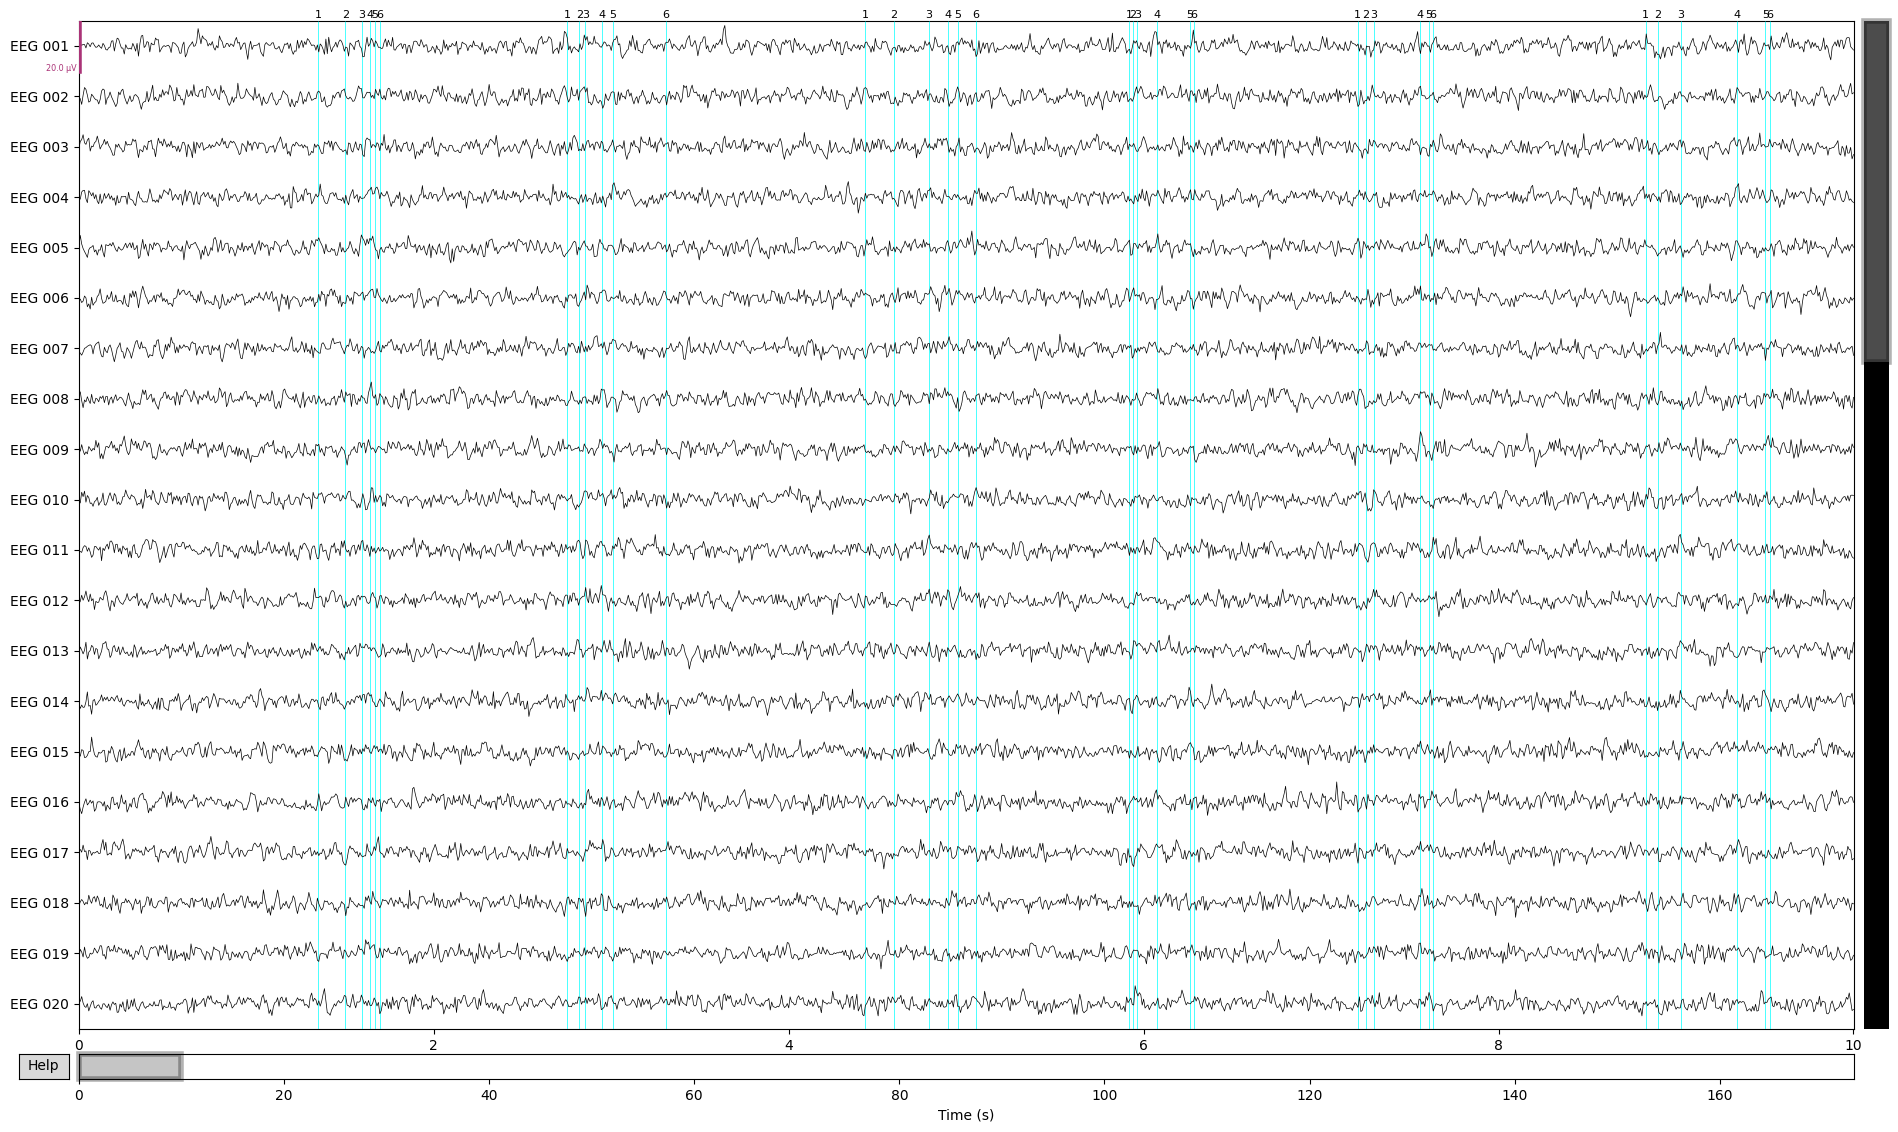

In [3]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}
#Keeping only stimulus and response triggers

#Visualising the raw simulated EEG data
import mne
raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
raw.pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events, block=True);


### Data Format 
We now prepare the data for the HMP package. First, we read the data into an xarray.

In [4]:
### Reading the data
from hmp import io
epoch_data = io.read_mne_data(file[0], data_format='raw', event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, tmin =-.1, tmax=2, verbose=False,)#We add an offset to ensure a smooth estimation at the end of the RT
epoch_data

Processing participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/./dataset_raw.fif's raw eeg
100 trials were retained for participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/./dataset_raw.fif


<xarray.Dataset> Size: 30MB
Dimensions:      (participant: 1, epoch: 100, channel: 59, sample: 635)
Coordinates:
  * epoch        (epoch) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * channel      (channel) <U7 2kB 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * sample       (sample) int64 5kB 0 1 2 3 4 5 6 ... 629 630 631 632 633 634
    event_name   (epoch) object 800B 'stimulus' 'stimulus' ... 'stimulus'
    rt           (epoch) float64 800B 0.35 0.554 0.624 0.364 ... 0.48 0.468 0.36
  * participant  (participant) <U2 8B 'S0'
Data variables:
    data         (participant, epoch, channel, sample) float64 30MB -5.709e-0...
Attributes:
    sfreq:             500.0
    offset:            0
    lowpass:           40.0
    highpass:          0.10000000149011612
    lower_limit_rt:    0
    upper_limit_rt:    inf
    reject_threshold:  None
    n_trials:          100

The previous function epochs the data around our (simulated) stimuli, cut the EEG data at each RT value (with an offset to avoid edge effects) and stores any additional infomation along (here 'event_name').

xarray is a handy way of using matrices with named dimensions. For example we can now very easily draw an ERP:


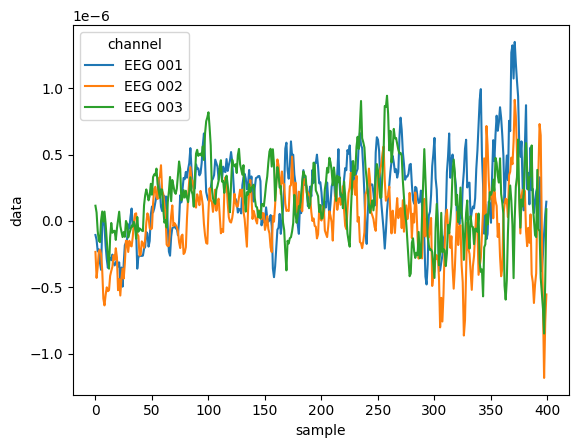

In [5]:
#example usage of xarray
epoch_data.sel(channel=['EEG 001','EEG 002','EEG 003'], sample=range(400))\
    .data.groupby('sample').mean(['participant','epoch']).plot.line(hue='channel')
plt.show()

### Data preprocessing

Next, we transform the data for HMP:
- Apply PCA and select top components to lower computational load
- zscore the data per trial

This analysis step asks you to choose a number of PC components; in the case of this illustration we just take 3 components for simplicity (more on this with real data in Tutorial 3).

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:165: UserWarning: Data will be modified inplace, re-read the data or use copy=True if multiplecalls to this function
  warn(


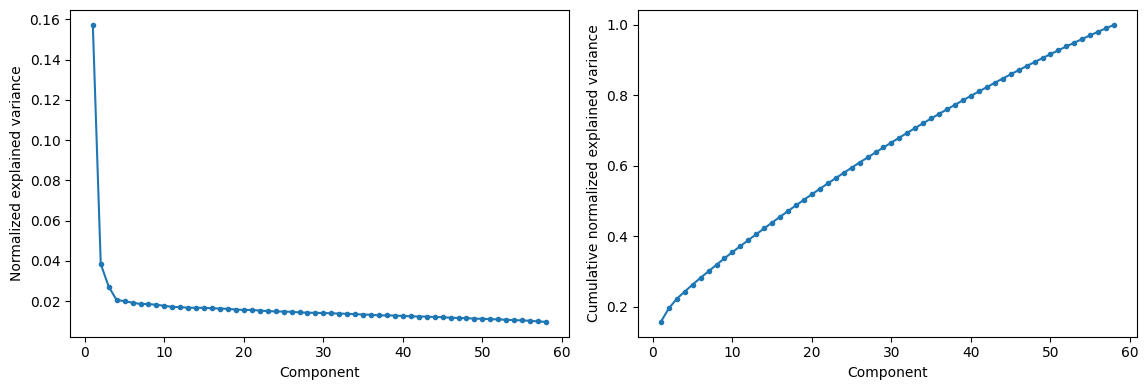

How many PCs (95 and 99% explained variance at component n54 and n57; components till n56 explain at least 1%)? 3


In [6]:
from hmp import preprocessing
preprocessed = preprocessing.Standard(epoch_data)

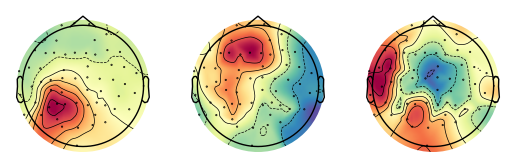

In [7]:
from hmp.visu import plot_components_sensor
plot_components_sensor(preprocessed.weights, info)
plt.show()

From now on the estimation performed by HMP will be done on these 3 virtual channels

## HMP and implementation assumptions

### Expected pattern

HMP assumes that a transition or cognitive event is represented in the data as a specific pattern.
Therefore, before estimating a model one needs to build such an expected event characteristics. 

The standard 50ms half-sine can be created by invoking the default `EventProperties` class. The class will then store the expected pattern given the sampling frequency of the data.

In [8]:
from hmp.patterns import HalfSine

event_properties = HalfSine.create_expected(sfreq=epoch_data.sfreq)
event_properties

HalfSine(sfreq=500.0, width_samples=25, location=25, template=array([0.00502324, 0.01499051, 0.02472136, 0.03406234, 0.04286614,
       0.05099392, 0.05831749, 0.06472136, 0.07010453, 0.07438212,
       0.07748665, 0.07936918, 0.08      , 0.07936918, 0.07748665,
       0.07438212, 0.07010453, 0.06472136, 0.05831749, 0.05099392,
       0.04286614, 0.03406234, 0.02472136, 0.01499051, 0.00502324]))

`event_properties.template` contains the default shape that we expect in the data, but we can replace that with whatever template we want if we have specific hypothesis: 

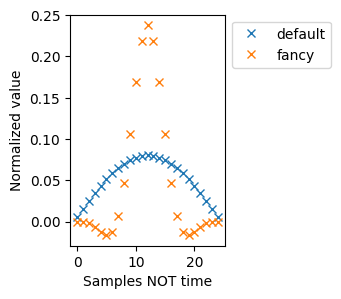

In [9]:
plt.figure(figsize=(2,3))
plt.plot(event_properties.template, 'x', label='default')
plt.ylabel('Normalized value')
plt.xlabel('Samples NOT time')

# Alternative template, just for fun
from scipy import signal
from hmp.patterns import Arbitrary

fancy = signal.windows.flattop(len(event_properties.template))
fancy = fancy/np.sum(fancy**2)#Normalizing as the original one
plt.plot(fancy, 'x', label='fancy')
plt.legend(bbox_to_anchor=(1,1))
plt.show();

If we wanted the fancy one we could simply do:
```python
from hmp.patterns import Arbitrary
event_properties = Arbitrary.create_expected(sfreq=epoch_data.sfreq, template=fancy)
```

We then create a `TrialData` class that combines the expected pattern with the data. The class will automatically cross-correlate the data with the provided template.

Below, we plot those cross-correlated values; the vertical lines indicate the start of the events in the simulated data.

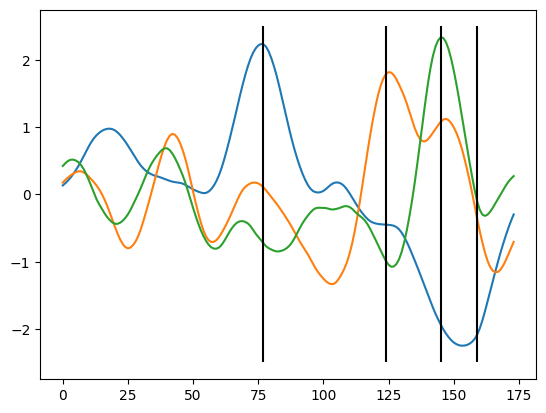

In [10]:
from hmp.trialdata import TrialData

trial_data = TrialData.from_preprocessed(preprocessed=preprocessed.data, pattern=event_properties.template)
plt.plot(trial_data.cross_corr[trial_data.starts[0]:trial_data.ends[0]])

#Recover the actual time of the simulated events
sim_source_times = np.reshape(np.ediff1d(events[:,0],to_begin=0)[events[:,2] > 1], (n_trials, n_events+1))
plt.vlines(sim_source_times[0,:-1].cumsum(), -2.5, 2.5, 'k') #overlaying the simulated event onset times
plt.show()

The specific pattern to be expected is an open discussion, given the transient and oscillatory nature of E/MEG signals, a half-sine is a good starting point. The specific width (or frequency) of the half-sine is more crucial (see tutorial on assumption and the simulations in the [paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00400/125469/Trial-by-trial-detection-of-cognitive-events-in)), overall the shorter the pattern the better up to the point were high frequency noise gets in the way of the estimation. 

Based on experience, a pattern width between 30 and 50ms generally provides the most robust solutions (but caution regarding the number of points in the pattern given the sampling rate, e.g. no use to take a 100Hz signal with a 30ms half-sine as the pattern would only be defined on three points) 

### Expected time distribution

Next HMP assumes that the time of the event peak follow a specific one-parameter time distribution. By default we expect event peak times to vary per-trial according to a Gamma distribution with a shape of 2 and a scale free to vary:

In [11]:
from hmp.distributions import Gamma

gamma_2 = Gamma()
gamma_2

For example an event happening on average 100ms following stimulus would have the blue distribution given a Gamma with a shape of 2 or the orange one with a Weibull and a shape of 5.

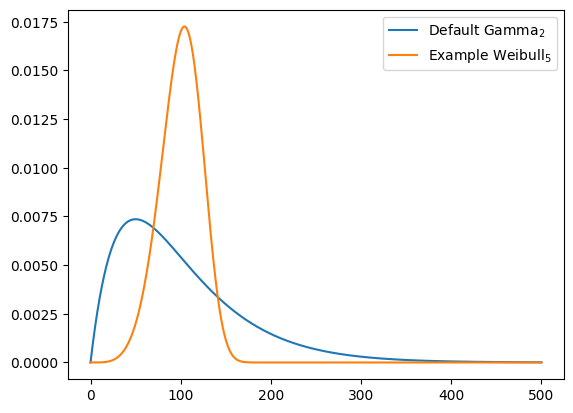

In [12]:
example_mean = 100
x = np.linspace(0, 500, 1000)
plt.plot(x, gamma_2.pdf(x, gamma_2.shape, 
        scale=gamma_2.mean_to_scale(example_mean)),
        label=r'Default Gamma$_2$')

## Other distribution to illustrate
from hmp.distributions import Weibull

other_time_distribution = Weibull(shape=5)
plt.plot(x, other_time_distribution.pdf(x, other_time_distribution.shape, 
        scale=other_time_distribution.mean_to_scale(example_mean)),
        label=r'Example Weibull$_5$')
plt.legend()
plt.show()

Overall the specific distribution doesn't really matter (see tutorials on assumptions and the appendix of the [paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00400/125469/Trial-by-trial-detection-of-cognitive-events-in)). The most important thing is to not exclude likely times (e.g. the Weibull doesn't allow event to happen directly after the stimulus for example). 

> [!NOTE]
> Declaring a time distribution is not a requirement, if you don't provide one, HMP will assume a Gamma distribution with a shape of 2 and a scale free to vary. This is the default setting and works well in most cases.


## An HMP model

After having defined the expected event pattern, cross-correlated it with the transformed data, and the overall shape of the by-trial time distributions we can create a proper HMP model. In this case we'll use the `EventModel` which is a model with a pre-defined number of events (more on the different model classes in the next tutorial).

In [13]:
from hmp.models import EventModel
model_true = EventModel(event_properties, gamma_2, n_events=n_events,
                        max_iteration=0)#max_iteration=0 prevents from actually going through the EM
model_true.fit(trial_data, verbose=False)# Just to illustrate the default starting points

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/models/event.py:559: RuntimeWarning: Convergence failed, estimation hit the maximum number of iterations: (0)
  warn(


### HMP parameters

Given an expected number of events, the model will estimate the parameters of the distribution of the time interval between events and the contribution of each channel (here principal components) to each event. In this simulation case we know when in time we simulated each event and also what channels were associated with which source, so we can use this information to estimate the ground truth model. The following cell basically extract those true parameters but of course only works on simulated data.

In [14]:
# `events` refers to the actual simulation times of the events, specific to simulations only
sim_source_times, true_time_pars, true_channel_pars, _ = \
        simulations.simulated_times_and_parameters(events, model_true, trial_data)

#### Time parameters

The `time_pars` attribute of an HMP model contains the time parameter of the choosen distribution for each event. The matrix below is a 2D array where each row corresponds to an event and each column corresponds to a parameter of the time distribution (in this case the Gamma distribution). The first column is the shape parameter (fixed in the cells above) and the second column is the scale parameter (that will be updated as we estimate an HMP model).

In [15]:
# Fixing true parameter in model, specific to simulations
model_true.time_pars = np.array([true_time_pars])
model_true.time_pars

array([[[ 2, 15],
        [ 2, 35],
        [ 2, 51],
        [ 2, 21],
        [ 2, 18]]])

If we represent those as Gamma distributions we obtain the following probability densities (the expected mean of a gamma is `shape * scale`):

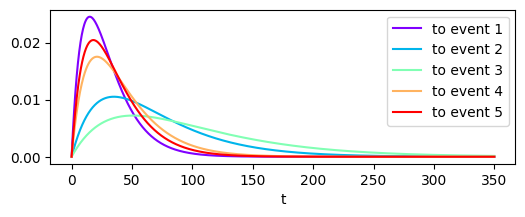

In [16]:
plt.figure(figsize=(6, 2))
colors = plt.cm.rainbow(np.linspace(0, 1, 5))

T = 350

for event in range(5):
    plt.plot(np.linspace(0, T, 1001),
             gamma_2.pdf(np.linspace(0, T, 1001), gamma_2.shape, scale=model_true.time_pars[0, event, 1]),
             label=f'to event {event+1}', color=colors[event])
plt.xlabel('t')
plt.legend()
plt.show()

The width of these distribution indicates the variability of the between-event durations over trials and (with real data) participants.

#### Channel parameters

The `channel_pars` attribute of an HMP model contains the contribution of each channel/PC to each event. The matrix below is a 2D array where each row corresponds to an event and each column corresponds to a channel.

In [17]:
# Fixing true parameter in model, specific to simulations
model_true.channel_pars = np.array([true_channel_pars])
model_true.channel_pars

array([[[ 2.27998886,  0.56456789, -0.59330625],
        [-0.39585184,  2.31361486, -0.72073836],
        [-2.11448823,  0.64686449,  1.16394691],
        [-2.16347821, -0.68996724, -1.56779367]]])

Again if we represent this visually we observe the following plot

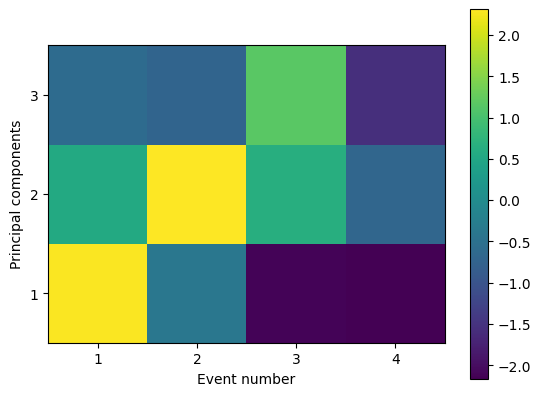

In [18]:
plt.imshow(model_true.channel_pars[0].T, origin="lower", )
plt.colorbar()
plt.ylabel('Principal components')
plt.xlabel('Event number')
plt.yticks(np.arange(trial_data.n_dims), np.arange(trial_data.n_dims)+1)
plt.xticks(np.arange(n_events), np.arange(n_events)+1)
plt.show()

We used 3 PC components (y-axis) to estimate 4 events. As is visible in the matrix above, each event has a unique combination of component contributions, although this is not a requirement.

### Transforming the data to event probability space using these parameters

As an exceedingly simple example, we will first feed these true time and channel parameters into the HMP model fitting procedure as starting points.
We then call the `transform` method which gives, for a set of time and channel parameters, the probability associated with each event for each E/MEG sample.

In [19]:
# Transforming to event probability space
loglikelihood_true, estimates_true = model_true.transform(trial_data, )

We can now look at the probabilities associated with this true model

In [20]:
estimates_true

<xarray.DataArray (trial: 100, sample: 635, event: 4)> Size: 2MB
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.36961982e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.93104762e-04, 2.52932334e-08, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.93831734e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.46882519e-05, 1.73446839e-10, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.80817488e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.10902687e-03, 4.19061895e-08, 0.00000000e+00, 0.00000000e+00],
        ...,
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.72071206e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.19141844e-03, 9.69906315e-08, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.98942694e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.39774090e-03, 1.66111329e-08, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],
      shape=(100, 635, 4))
Coordinates:
  * event        (event) int64 32B 0 1 2 3
  * sample       (sample) int64 5kB 0 1 2 3 4 5 6 ... 629 630 631 632 633 634
  * trial        (trial) object 800B MultiIndex
  * participant  (trial) object 800B 'S0' 'S0' 'S0' 'S0' ... 'S0' 'S0' 'S0' 'S0'
  * epoch        (trial) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
    group        (trial) int8 100B 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    sfreq:                500.0
    event_width_samples:  25

This is a matrix with dimensions trial x sample_in_trial x event, where the values indicate the probablity of that event occurring at that sample.

We can represent this graphically, for example by plotting the average probability for each event at each time sample:

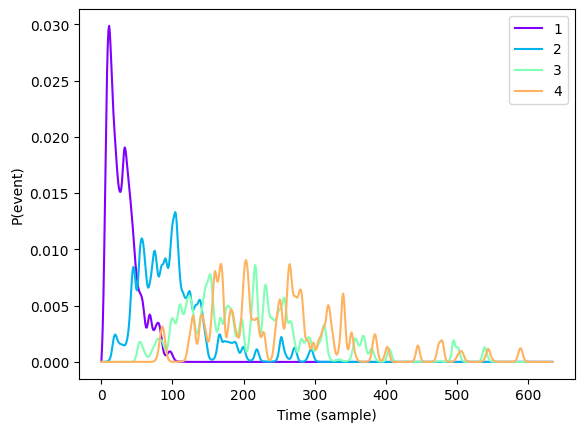

In [21]:
for event in range(n_events):
    plt.plot(estimates_true.sel( event=event).mean('trial'), label=event+1, 
            color=colors[event])
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.legend()
plt.show()

And we can even look at a single trial:

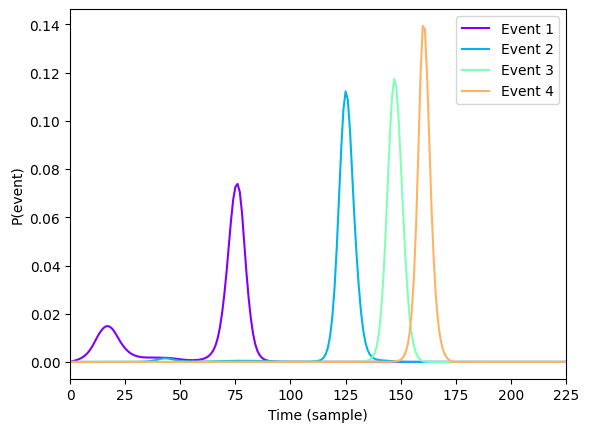

In [22]:
for event in range(n_events):
    plt.plot(estimates_true.sel(trial=('S0',0), event=event), label=f"Event {event+1}", 
            color=colors[event])
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.xlim(0,225)
plt.legend()
plt.show()

**Note** In this trial there is a first bump in the probabilities for the 1st event (and the smaller one for the 2nd event). This is because the time distribution of this first event expect it to happen most of the time before sample 50 (thus some likelihood is also given to the next one starting early). But in this case, the simulated event was later, thus the initial time expectation was overweighted by the fact that an event with very similar topography happened slightly later.

#### Visualizing the average time location and topographies associated with the estimated events

Now the above plots might not be the most informative visually, what we can do is average the electrodes values at each most likely time point of each event, and then plot the topographies associated with these times. This gives us a nice overview of the average event position and the topographies associated with each event.

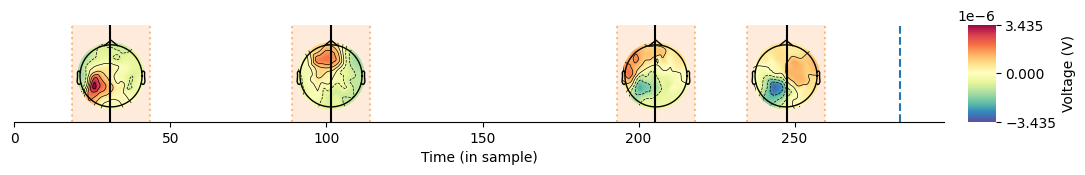

In [23]:
# Visualize the average event position and the topographies assocaited with each event
hmp.visu.plot_topo_timecourse(epoch_data, estimates_true, info, times_to_display=None)
plt.vlines(np.mean(np.cumsum(sim_source_times,axis=1),axis=0)[:-1], np.repeat(0,4), np.repeat(1,4), zorder=10, color='k')
plt.show()

In the plot above we see the four recovered events; the vertical lines again indicate the average peak time of the simulated events. Not surprisingly, as we just used the true time and channel parameters, the recovery is perfect.

## Estimating a model without the ground truth

in real data, to estimate this unkown set of parameters (time and channel parameters) we use the expectation maximization algorithm on the event probability as obtained through the Baum-Welsh algorithm. 
We start with neutral guess on the time and channel parameters (0's for `channel_pars`, and mean RT / n_events for the `time_pars`).

Estimating 4 events model with 1 starting point(s)


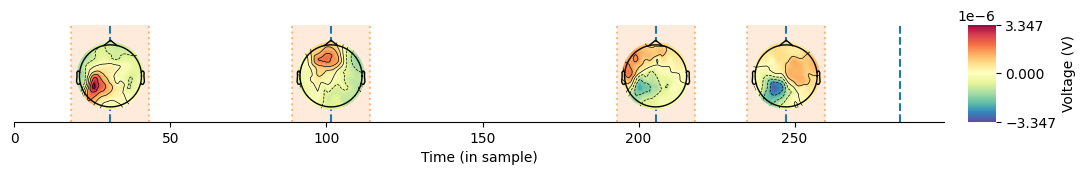

In [24]:
#r Defining a fresh model as we would do for real data
model = EventModel(event_properties, gamma_2, n_events=n_events)
loglikelihood, estimates = model.fit_transform(trial_data)#This function simultaneously estimates the paraneters and transform the data to event probability space

hmp.visu.plot_topo_timecourse(epoch_data, estimates, info)
plt.show()

Also without providing the true magnitudes and parameters, the algorithm manages to recover the events, **on average**, in the simulated data.

### EM algorithm

Under the hood, HMP uses an expectation maximization algorithm to find the solution that best explains the data. The way it works is:
1. make a first proposal on the time location and channel contribution towards each event
2. Compute the most likely location of the events given this proposition
3. Update the parameters according to this most likely position
4. Repeat steps 2-3 up to the moment where the loglikelihood of the data stops increasing more than the tolerance criterion (default 1e-4)

More details about the algorithm can be found in the accompanying 2024 [paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00400/125469/Trial-by-trial-detection-of-cognitive-events-in)

We can inspect the traces of this EM algorithm to see how the log-likelihood of the fit developed with iterations. This shows how many iterations it needed and at what Log-likelihood (LL) it stopped according to the default tolerance on the increase in LL (default 1e-4).

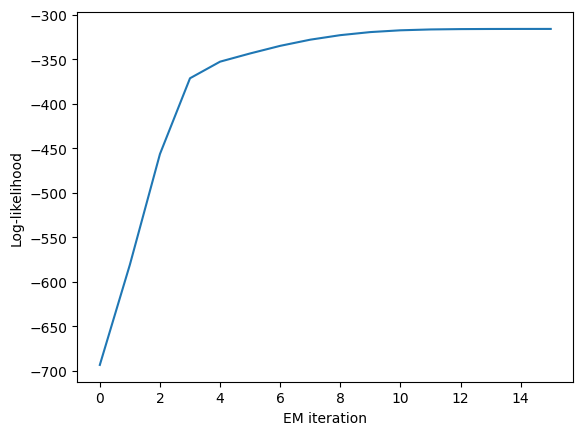

In [25]:
plt.plot(model.traces)
plt.ylabel('Log-likelihood')
plt.xlabel('EM iteration')
plt.show()

Along this we can take a look at how the position of the events were updated, i.e. how the time parameters changed according to the evolution of the EM algorithm:

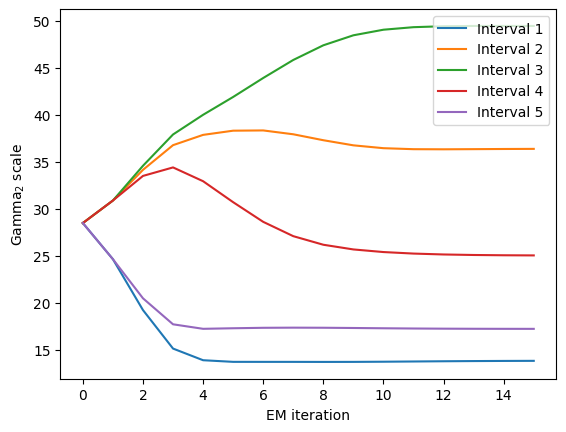

In [26]:
plt.plot(model.time_pars_dev[:,0,:,1], label=['Interval '+str(x) for x in [1,2,3,4,5]])
plt.ylabel(r'Gamma$_2$ scale')
plt.xlabel('EM iteration')
plt.legend(loc=1)
plt.show()

Here we see that the the first EM iteration starts with the assumption that all events are equally spaced in the RT. Then for example the first interval progressively became shorter while the second one became longer. As we progress in the EM iteration the time distribution parameters get more stable. We can increase the tolerance but this, most of the time, wouldn't have much consequences except making the fit slower: 

Estimating 4 events model with 1 starting point(s)


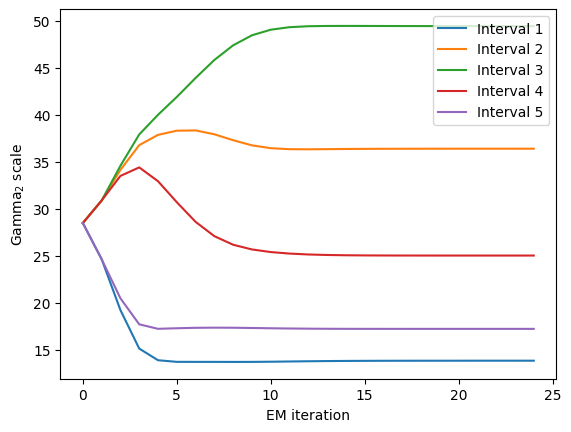

In [27]:
#re-defining the model to remove previous run
lowtol_model = EventModel(event_properties, gamma_2, n_events=n_events, tolerance=1e-10)
lowtol_loglikelohood, lowtol_estimates = lowtol_model.fit_transform(trial_data)
plt.plot(lowtol_model.time_pars_dev[:,0,:,1], label=['Interval '+str(x) for x in [1,2,3,4,5]])
plt.ylabel(r'Gamma$_2$ scale')
plt.xlabel('EM iteration')
plt.legend(loc=1)
plt.show()

Here the profile is exactly the same except that the EM algorithm went through a few more iterations.

## Using the single trial estimation

If we select for all trials the most likely sample to contain a transition (e.g. the maximum probability in the single trial plot with p(events) on the y-axis) we can take a look at the recovery of our simulated times on all trials:

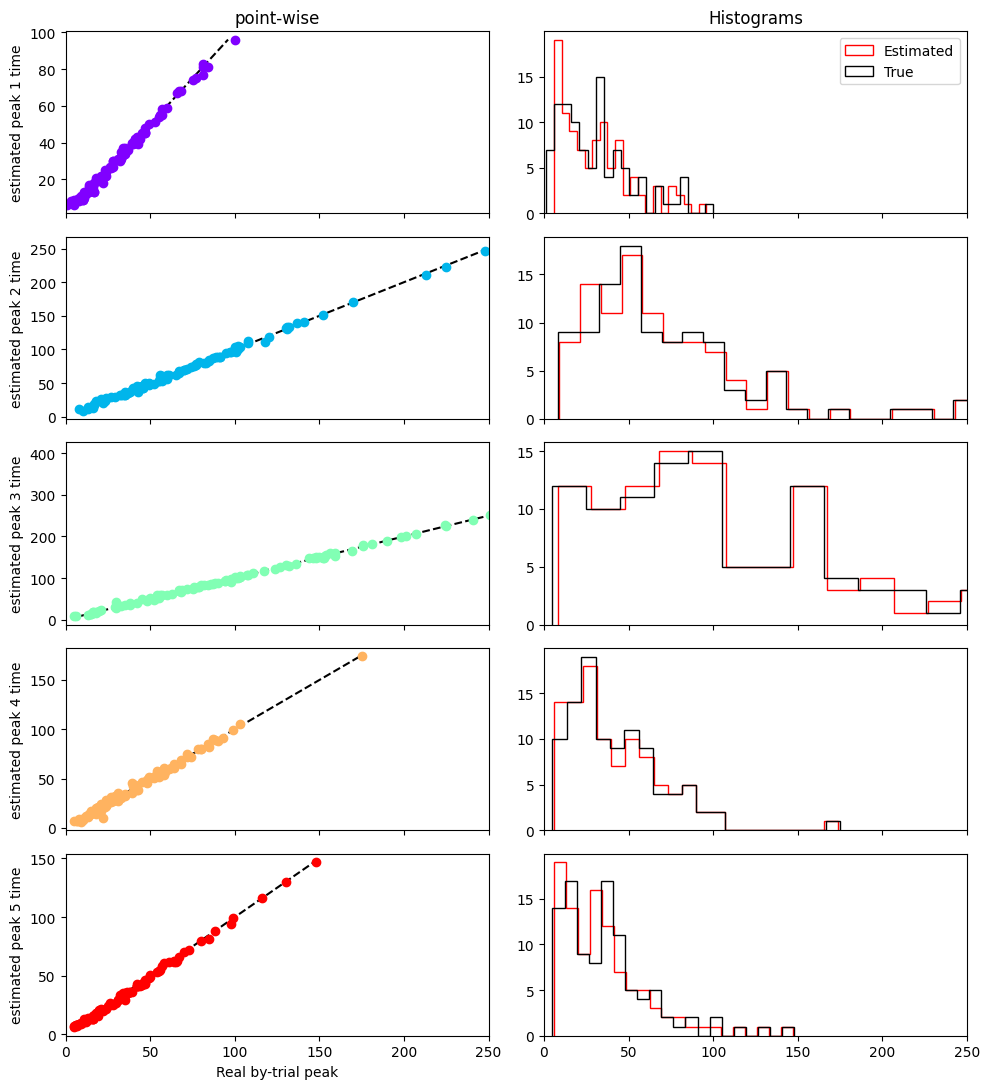

In [28]:
# Estimate the duration between events based on the most time for each event at each trial
estimated_times = hmp.utils.event_times(estimates, duration=True, mean=False, add_rt=True).T

fig, ax = plt.subplots(n_events+1,2, figsize=(10,2.5*n_events+1), dpi=100, sharex=True)
i = 0
ax[0,0].set_title('point-wise')
ax[0,1].set_title('Histograms')
ax[-1,0].set_xlabel(f'Real by-trial peak')

for event in estimated_times:
    ax[i,0].plot([np.min(event), np.max(event)], [np.min(event), np.max(event)],'--', color='k')

    ax[i,0].plot(sim_source_times[:,i], event, 'o', color=colors[i])
    ax[i,0].set_ylabel(f'estimated peak {i+1} time')
    ax[i,1].hist(event, color='red', bins=20, histtype='step', label='Estimated')
    ax[i,1].hist(sim_source_times[:,i].T, color='k', bins=20, histtype='step', label='True')
    i+= 1
ax[0,-1].legend()
plt.xlim(0,250)
plt.tight_layout()
plt.show()

Overall the exact time of the simulated event is detected as the most likely time by HMP! Of course this will depend on the signal to noise ratio and the non-violation of HMP's assumptions (see the simulations in the [paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00400/125469/Trial-by-trial-detection-of-cognitive-events-in))

## Saving and loading a model

Depending on the size of the data (with main factor the sampling rate) the HMP model can take a while to estimate. Therefore, it is often useful to save the model and the estimates for later use. 

In [29]:
import pickle
with open("model.pkl", 'wb') as output:
    pickle.dump(model, output)
    

# Same goes fpr the estimates
with open("estimates.pkl", 'wb') as output:
    pickle.dump(estimates, output)
    

For those who are not conmortable in continuing in python you also have the option to just export the estimated event probabilities to a csv for use in other languages/softwares

In [30]:
io.save_eventprobs_csv(estimates, 'estimates.csv')
import pandas as pd
df_estimates = pd.read_csv('estimates.csv')
print(df_estimates)

Saved at estimates.csv
        sample  event participant  epoch  group  eventprobs
0            0      0          S0      0      0         0.0
1            0      0          S0      1      0         0.0
2            0      0          S0      2      0         0.0
3            0      0          S0      3      0         0.0
4            0      0          S0      4      0         0.0
...        ...    ...         ...    ...    ...         ...
253995     634      3          S0     95      0         0.0
253996     634      3          S0     96      0         0.0
253997     634      3          S0     97      0         0.0
253998     634      3          S0     98      0         0.0
253999     634      3          S0     99      0         0.0

[254000 rows x 6 columns]
